# Week 4 - Convolutional Neural Networks

## Importing libraries and dependencies

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Convert images into Tensors

In [156]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])



In [157]:
train_data = ImageFolder(
    "clouds_dataset/clouds_train",
    transform = transform
)

In [158]:
train_data

Dataset ImageFolder
    Number of datapoints: 474
    Root location: clouds_dataset/clouds_train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomAutocontrast(p=0.5)
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [159]:
test_data = ImageFolder(
    "clouds_dataset/clouds_test",
    transform = transform
)

In [160]:
test_data

Dataset ImageFolder
    Number of datapoints: 486
    Root location: clouds_dataset/clouds_test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomAutocontrast(p=0.5)
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

## Creating loaders

In [161]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Creating the model class

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        """
        Initializes the ConvolutionalNeuralNetwork model.

        This CNN is designed for image classification, featuring three convolutional
        layers followed by batch normalization, ReLU activation, and max-pooling operations.
        It concludes with a fully connected layer (with dropout) for classification.
        It expects 64x64 pixel RGB images as input.

        Args:
            num_classes (int): The number of output classes for the classification task.
                               This determines the size of the final fully connected layer's output.
        """
        super().__init__()

        # --- First convolutional block ---
        # Input channels: 3 (for RGB images)
        # Output channels: 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Batch Normalization for the first conv layer's output
        self.bn1 = nn.BatchNorm2d(32)

        # --- Second convolutional block ---
        # Input channels: 32 (output from conv1)
        # Output channels: 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Batch Normalization for the second conv layer's output
        self.bn2 = nn.BatchNorm2d(64)

        # --- Third convolutional block ---
        # Input channels: 64 (output from conv2)
        # Output channels: 128 (You can choose a different number here, often powers of 2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Batch Normalization for the third conv layer's output
        self.bn3 = nn.BatchNorm2d(128)

        # --- Fully connected layer ---
        # Recalculate the input features for the FC layer:
        # Original input image size: 64x64

        # After conv1 (3x3 kernel, stride=1, padding=1): size remains 64x64
        # After first max_pool2d (kernel=2, stride=2): size becomes 64 / 2 = 32x32

        # After conv2 (3x3 kernel, stride=1, padding=1): size remains 32x32
        # After second max_pool2d (kernel=2, stride=2): size becomes 32 / 2 = 16x16

        # After conv3 (3x3 kernel, stride=1, padding=1): size remains 16x16
        # After third max_pool2d (kernel=2, stride=2): size becomes 16 / 2 = 8x8

        # The number of input features for fc1 will be:
        # final_out_channels_from_conv_block * final_feature_map_width * final_feature_map_height
        # In this case: 128 * 8 * 8 = 8192
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=num_classes)

        # --- Dropout layer ---
        # Helps prevent overfitting by randomly setting a fraction of input units to zero
        # during training. Common values are 0.25 to 0.5.
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Defines the forward pass of the ConvolutionalNeuralNetwork.

        Args:
            x (torch.Tensor): The input tensor, expected to be of shape
                              (batch_size, 3, 64, 64) for RGB images.

        Returns:
            torch.Tensor: The log-softmax probabilities for each class,
                          of shape (batch_size, num_classes).
        """
        # --- First convolutional block ---
        # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.conv1(x)
        x = self.bn1(x) # Apply Batch Normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # Spatial dimensions: 64x64 -> 32x32

        # --- Second convolutional block ---
        # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.conv2(x)
        x = self.bn2(x) # Apply Batch Normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # Spatial dimensions: 32x32 -> 16x16

        # --- Third convolutional block ---
        # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.conv3(x)
        x = self.bn3(x) # Apply Batch Normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # Spatial dimensions: 16x16 -> 8x8

        # Flatten the feature maps into a 1D vector for the fully connected layer.
        x = x.view(-1, 128 * 8 * 8)

        # Apply Dropout before the final fully connected layer to prevent overfitting.
        x = self.dropout(x)

        # Apply the fully connected layer to produce raw class scores.
        x = self.fc1(x)

        # Apply log-softmax to get log-probabilities, typically used with NLLLoss or CrossEntropyLoss.
        return F.log_softmax(x, dim=1)

## Create an instance of the model

In [163]:
num_classes = len(train_data.classes)
print(f"Classes found: {train_data.classes}")
print(f"Number of classes: {num_classes}")

Classes found: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']
Number of classes: 7


In [164]:
torch.manual_seed(41)
model = ConvolutionalNeuralNetwork(num_classes)
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Define loss function optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Train and Test

In [166]:
epochs = 25
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    current_train_loss = 0 # To accumulate training loss for the epoch

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1 # Start batches at 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train) # Compare predictions to correct answers
        current_train_loss += loss.item() # Accumulate loss

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(trn_corr) 

    # Test
    with torch.no_grad(): # No gradient
        current_test_loss = 0 # To accumulate test loss for the epoch
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss_test = criterion(y_val, y_test) # Calculate loss for test set
            current_test_loss += loss_test.item()

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    # Average test loss for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

    # Print results at the end of each epoch
    print(f'Epoch {i+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/25, Loss: 1.1367
Epoch 2/25, Loss: 1.4327
Epoch 3/25, Loss: 1.6230
Epoch 4/25, Loss: 3.6693
Epoch 5/25, Loss: 2.7506
Epoch 6/25, Loss: 4.4337
Epoch 7/25, Loss: 3.6846
Epoch 8/25, Loss: 2.5349
Epoch 9/25, Loss: 3.6698
Epoch 10/25, Loss: 4.5711
Epoch 11/25, Loss: 5.5427
Epoch 12/25, Loss: 3.6236
Epoch 13/25, Loss: 6.4366
Epoch 14/25, Loss: 5.4070
Epoch 15/25, Loss: 2.1985
Epoch 16/25, Loss: 4.3753
Epoch 17/25, Loss: 4.5331
Epoch 18/25, Loss: 5.7525
Epoch 19/25, Loss: 2.9968
Epoch 20/25, Loss: 4.1739
Epoch 21/25, Loss: 4.0862
Epoch 22/25, Loss: 4.5011
Epoch 23/25, Loss: 2.4523
Epoch 24/25, Loss: 4.3600
Epoch 25/25, Loss: 3.7921


## Loss at each Epoch

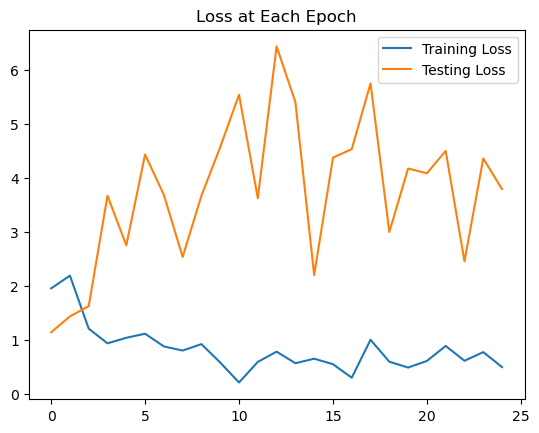

In [167]:
# Transform tensors into a list
train_losses = [tl.item() for tl in train_losses]

# Graph loss at each epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Each Epoch')
plt.legend()

# Accuracy at the end of each epoch

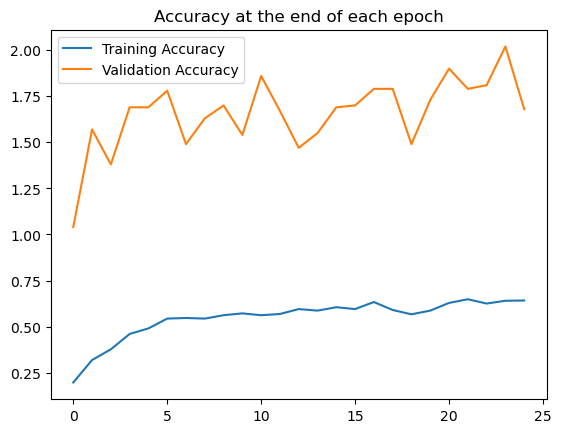

In [168]:
# Graph accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

## Percentage of Accuracy

In [169]:
test_load_everything = DataLoader(test_data, batch_size=486, shuffle=False)

In [170]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [171]:
correct.item()/len(test_data)

0.7263374485596708